Data dictionary can be found here:
https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [2]:
df = pd.read_csv("credit card default.csv")

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df.shape

(30000, 25)

In [5]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,1,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Data Cleaning and Exploration

In [6]:
df.describe()
# There are negative amounts eg in BILL_AMT
## It is apparently possible to have a negative bill amount by overpaying

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603700,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489136,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [7]:
df.isna().sum() # No NA values, can also be seen from above when the count of each column is the same as df.shape[0]

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [8]:
df.duplicated().sum() # No 2 rows are duplicates

0

In [9]:
df.ID.duplicated().sum() # No ID duplicates

0

In [10]:
df.dtypes
# Strictly speaking Sex, Education, Marriage, default payment next month should be categorical

ID                            int64
LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object

In [11]:
df.rename(columns={"PAY_0":"PAY_1"}, inplace=True)
# PAY BILL_AMT and PAY_AMT variables correspond to one another, and PAY_1 is missing, so PAY_0 is likely supposed to be PAY_1

In [12]:
# Investigate if the PAY_ variables are categorical or int
for i in range(6,12):
    print(df.columns[i],":",df.iloc[:,i].unique(), "\n")
# They all generally have values from -1 to 8 (except PAY_5 and PAY_6 missing 1)
# --> so likely to be categorical. 
# This is supported by the fact that there are other columns called PAY_AMT which represent the actual values

PAY_1 : [ 2 -1  0 -2  1  3  4  8  7  5  6] 

PAY_2 : [ 2  0 -1 -2  3  5  7  4  1  6  8] 

PAY_3 : [-1  0  2 -2  3  4  6  7  1  5  8] 

PAY_4 : [-1  0 -2  2  3  4  5  7  6  1  8] 

PAY_5 : [-2  0 -1  2  3  5  4  7  8  6] 

PAY_6 : [-2  2  0 -1  3  6  4  7  8  5] 



X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. *(Reverse order)* The measurement scale for the repayment status is:

-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

In [13]:
# Convert to categorical variables
cat_vars = [f"PAY_{_}" for _ in range(1,7)]
cat_vars.extend(["SEX","EDUCATION", "MARRIAGE", "default payment next month"])
#print(cat_vars)

for x in cat_vars:
    df[x] = df[x].astype("category")

In [14]:
#df.describe(include="category")

In [15]:
for x in cat_vars:
    print(x,"\n",df[x].value_counts(), "\n")

PAY_1 
  0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_1, dtype: int64 

PAY_2 
  0    15730
-1     6050
 2     3927
-2     3782
 3      326
 4       99
 1       28
 5       25
 7       20
 6       12
 8        1
Name: PAY_2, dtype: int64 

PAY_3 
  0    15764
-1     5938
-2     4085
 2     3819
 3      240
 4       76
 7       27
 6       23
 5       21
 1        4
 8        3
Name: PAY_3, dtype: int64 

PAY_4 
  0    16455
-1     5687
-2     4348
 2     3159
 3      180
 4       69
 7       58
 5       35
 6        5
 8        2
 1        2
Name: PAY_4, dtype: int64 

PAY_5 
  0    16947
-1     5539
-2     4546
 2     2626
 3      178
 4       84
 7       58
 5       17
 6        4
 8        1
Name: PAY_5, dtype: int64 

PAY_6 
  0    16286
-1     5740
-2     4895
 2     2766
 3      184
 4       49
 7       46
 6       19
 5       13
 8        2
Name: PAY_6, dtype: int64 

SEX 
 2    18111

## Visualisations 

### Distributions of selected individual variables 

<AxesSubplot:xlabel='default payment next month', ylabel='count'>

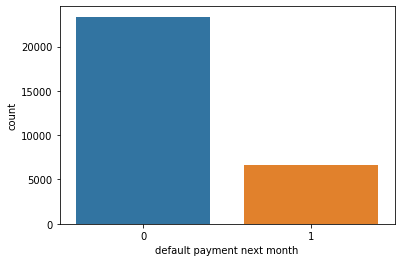

In [16]:
# Default payment next month
sns.countplot(data=df, x="default payment next month")
# Imbalanced

In [17]:
df["default payment next month"].value_counts(normalize=True) #78% 0 #22% 1

0    0.7788
1    0.2212
Name: default payment next month, dtype: float64

<AxesSubplot:xlabel='LIMIT_BAL'>

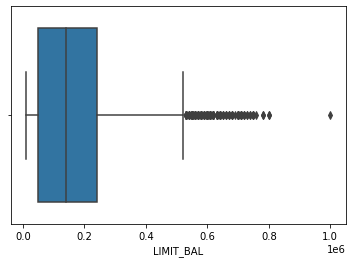

In [18]:
# LIMIT_BAL
sns.boxplot(data=df, x="LIMIT_BAL")
# Median balance about 150,000
# No evidence to suggest that the outliers are reasonable/incorrect. 
## Some customers can have high credit and thus high limit balance

<AxesSubplot:xlabel='LIMIT_BAL', ylabel='Count'>

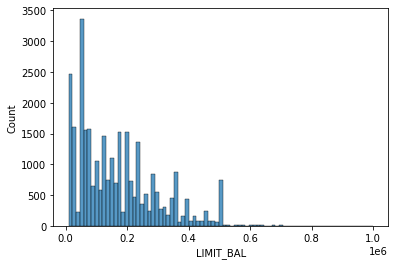

In [19]:
sns.histplot(data=df, x="LIMIT_BAL")
# Skewed

<AxesSubplot:xlabel='AGE', ylabel='Count'>

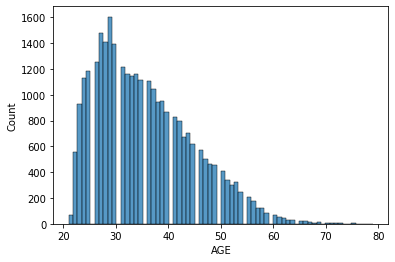

In [20]:
# AGE
sns.histplot(data=df, x="AGE")
# Skewed
# Interestingly there are some bins with no count

<AxesSubplot:xlabel='AGE'>

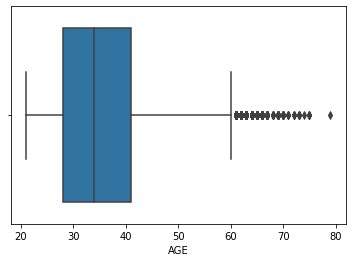

In [21]:
sns.boxplot(data=df, x="AGE")
# Median age around <35
# No evidence to suggest that the outliers are reasonable/incorrect. 
## Very reasonable that there are customers above 60 but less than 80

<AxesSubplot:xlabel='PAY_6', ylabel='count'>

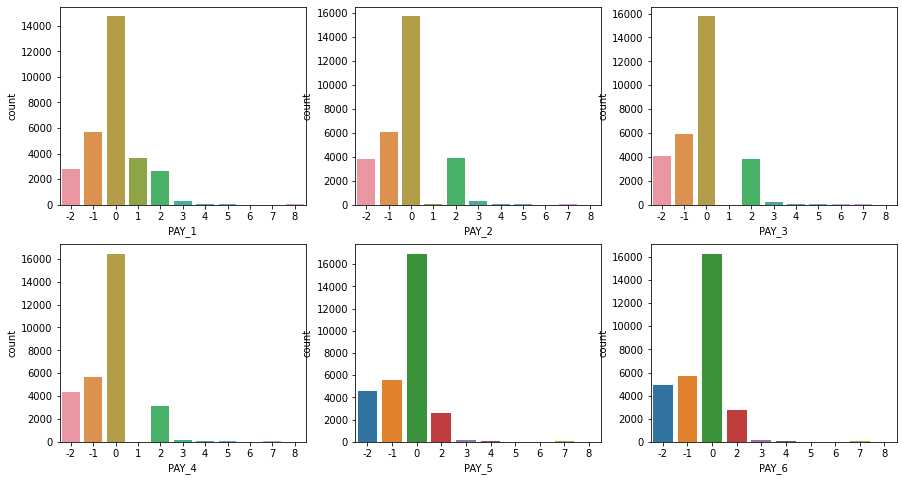

In [22]:
# PAY
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(ncols=3, nrows=2, figsize=(15,8))
sns.countplot(data=df, x="PAY_1", ax=ax1)
sns.countplot(data=df, x="PAY_2", ax=ax2)
sns.countplot(data=df, x="PAY_3", ax=ax3)
sns.countplot(data=df, x="PAY_4", ax=ax4)
sns.countplot(data=df, x="PAY_5", ax=ax5)
sns.countplot(data=df, x="PAY_6", ax=ax6)
# Customers most commonly have PAY category = 0 (i.e. revolving credit)

[Text(0.5, 0, 'BILL_AMT6'), Text(0, 0.5, ''), (-200000.0, 1000000.0)]

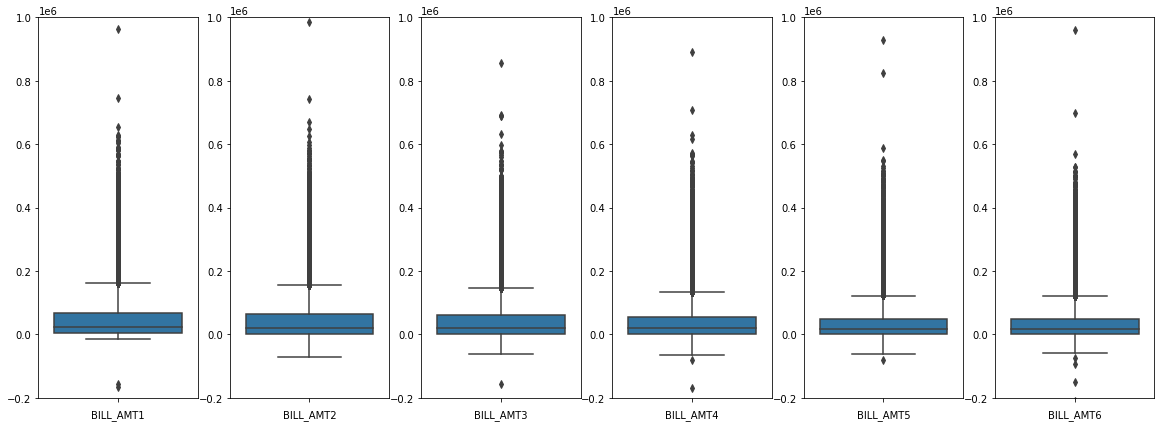

In [23]:
# BILL_AMT
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20,7))
sns.boxplot(data=df, y="BILL_AMT1", ax=ax1).set(xlabel="BILL_AMT1", ylabel="", ylim=(-200000, 1000000))
sns.boxplot(data=df, y="BILL_AMT2", ax=ax2).set(xlabel="BILL_AMT2", ylabel="", ylim=(-200000, 1000000))
sns.boxplot(data=df, y="BILL_AMT3", ax=ax3).set(xlabel="BILL_AMT3", ylabel="", ylim=(-200000, 1000000))
sns.boxplot(data=df, y="BILL_AMT4", ax=ax4).set(xlabel="BILL_AMT4", ylabel="", ylim=(-200000, 1000000)) 
sns.boxplot(data=df, y="BILL_AMT5", ax=ax5).set(xlabel="BILL_AMT5", ylabel="", ylim=(-200000, 1000000))
sns.boxplot(data=df, y="BILL_AMT6", ax=ax6).set(xlabel="BILL_AMT6", ylabel="", ylim=(-200000, 1000000))
# No evidence to suggest that the outliers are reasonable/incorrect. 
## It is possible to overpay and thus have a negative bill. It is also possible that people have a high bill,
## especially considering the amounts are in New Taiwan dollar (1 S$: approximately 21 NT$) 
## and the fact that the limit balance can also be 1,000,000

[Text(0.5, 0, 'PAY_AMT6'), Text(0, 0.5, ''), (-100000.0, 1000000.0)]

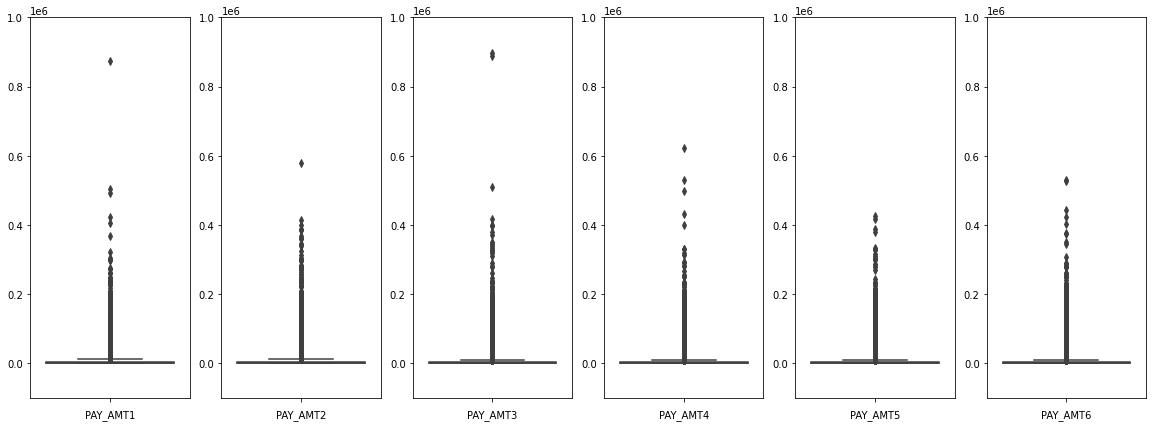

In [24]:
# PAY_AMT
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20,7))
sns.boxplot(data=df, y="PAY_AMT1", ax=ax1).set(xlabel="PAY_AMT1", ylabel="", ylim=(-100000, 1000000))
sns.boxplot(data=df, y="PAY_AMT2", ax=ax2).set(xlabel="PAY_AMT2", ylabel="", ylim=(-100000, 1000000))
sns.boxplot(data=df, y="PAY_AMT3", ax=ax3).set(xlabel="PAY_AMT3", ylabel="", ylim=(-100000, 1000000))
sns.boxplot(data=df, y="PAY_AMT4", ax=ax4).set(xlabel="PAY_AMT4", ylabel="", ylim=(-100000, 1000000)) 
sns.boxplot(data=df, y="PAY_AMT5", ax=ax5).set(xlabel="PAY_AMT5", ylabel="", ylim=(-100000, 1000000))
sns.boxplot(data=df, y="PAY_AMT6", ax=ax6).set(xlabel="PAY_AMT6", ylabel="", ylim=(-100000, 1000000))
# Very small IQR, min is 0 for all
# No evidence to suggest that the outliers are reasonable/incorrect, as explained above

### Visualisations of multiple variables at a time

<AxesSubplot:>

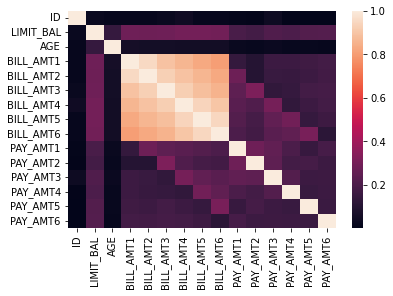

In [25]:
sns.heatmap(df.corr())
# BILL_AMT are highly correlated to each other. This may create an issue later e.g. logistic regression due to potential multicollinearity

Text(0, 0.5, '%')

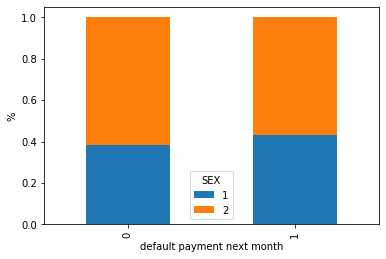

In [26]:
# Sex vs Default
ax = pd.crosstab(df["default payment next month"],df["SEX"], normalize="index").plot(kind="bar",stacked=True)
plt.ylabel("%")
# SEX=1 are slighlty more likely to default

Text(0, 0.5, '%')

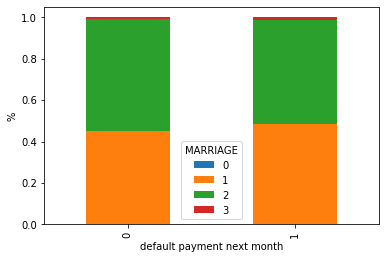

In [27]:
# Marriage vs Default
ax = pd.crosstab(df["default payment next month"],df["MARRIAGE"], normalize="index").plot(kind="bar",stacked=True)
plt.ylabel("%")
# Marriage seems to have no effect on default

Text(0, 0.5, '%')

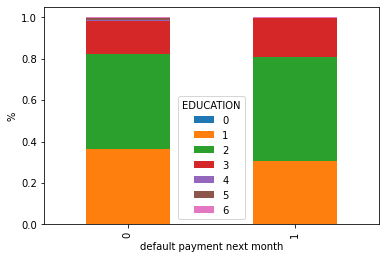

In [28]:
# Education vs Default
ax = pd.crosstab(df["default payment next month"],df["EDUCATION"], normalize="index").plot(kind="bar",stacked=True)
plt.ylabel("%")


<AxesSubplot:xlabel='LIMIT_BAL', ylabel='default payment next month'>

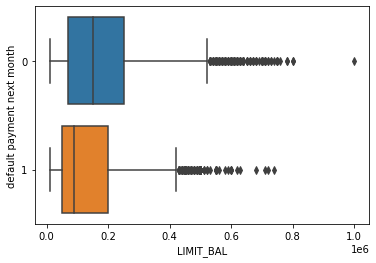

In [29]:
# LIMIT_BAL vs Default
# LIMIT_BAL
sns.boxplot(data=df, x="LIMIT_BAL", y="default payment next month")
# People who default have a lower limit balance - reasonable

<AxesSubplot:xlabel='AGE', ylabel='default payment next month'>

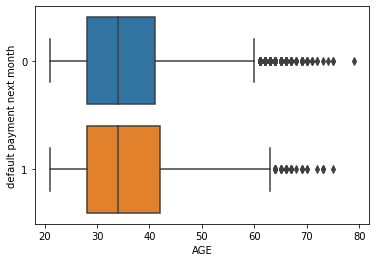

In [30]:
# Age vs Default
sns.boxplot(data=df, x="AGE", y="default payment next month")
# Median around the same, IQR almost the same

<AxesSubplot:xlabel='PAY_1', ylabel='count'>

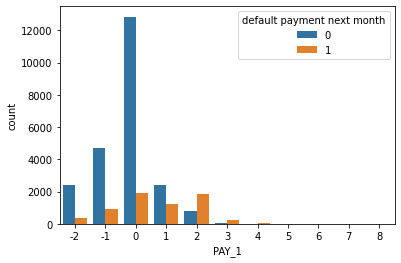

In [31]:
# PAY_1 vs default (Using PAY_1 as an example)
sns.countplot(data=df, x="PAY_1", hue="default payment next month")
# Defaulters have more payment delays compared to non-defaulters

<AxesSubplot:xlabel='BILL_AMT1', ylabel='default payment next month'>

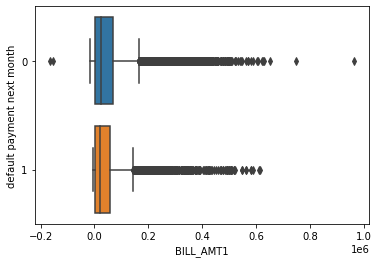

In [32]:
# BILL_AMT1 vs default
sns.boxplot(data=df, x="BILL_AMT1", y="default payment next month")

<AxesSubplot:xlabel='PAY_AMT1', ylabel='default payment next month'>

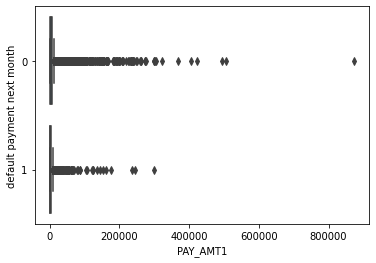

In [33]:
# PAY_AMT1 vs default
sns.boxplot(data=df, x="PAY_AMT1", y="default payment next month")

Text(0, 0.5, 'BILL_AMT')

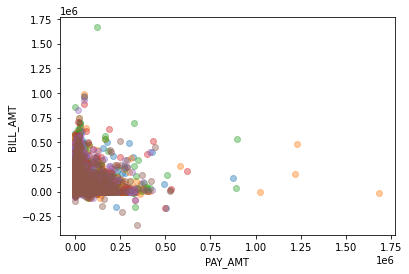

In [34]:
# BILL_AMT vs PAY_AMT
#fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,8))
a = 0.4
plt.scatter(data=df, x="PAY_AMT1", y="BILL_AMT1", alpha=a)
plt.scatter(data=df, x="PAY_AMT2", y="BILL_AMT2", alpha=a)
plt.scatter(data=df, x="PAY_AMT3", y="BILL_AMT3", alpha=a)
plt.scatter(data=df, x="PAY_AMT4", y="BILL_AMT4", alpha=a)
plt.scatter(data=df, x="PAY_AMT5", y="BILL_AMT5", alpha=a)
plt.scatter(data=df, x="PAY_AMT6", y="BILL_AMT6", alpha=a)
plt.xlabel("PAY_AMT")
plt.ylabel("BILL_AMT")
# Many clients who have high bills but pay a smaller amount
# Also have many clients who have low bills but may a higher amount

# Modelling

As there is a class imbalance noted earlier, should perform *stratified* train-test split as well as consider oversampling.<br>
Due to the large differences in the order of magnitude e.g. for PAY_AMT vs BILL_AMT, should perform scaling of X variables so that the model will not be biased towards X variables with larger magnitudes (e.g. BILL_AMT)

## Preprocessing 

In [16]:
df.drop("ID", axis=1, inplace=True)
# Drop ID as it is not a meaningful predictor

In [23]:
X = df.drop(["default payment next month"], axis=1)
Y = df["default payment next month"]

In [24]:
# Feature selection
features = SelectKBest(score_func=f_regression, k=5)
fit = features.fit(X, Y)
print(df.columns, fit.scores_)
mask = fit.get_support()
print(mask)
new_features = X.columns[mask]
print(new_features[:])

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object') [7.24068539e+02 4.82855084e+01 2.35471118e+01 1.77812714e+01
 5.78855582e+00 3.53771497e+03 2.23916914e+03 1.75746644e+03
 1.47684597e+03 1.30459118e+03 1.08540249e+03 1.15805315e+01
 6.04423789e+00 5.94438771e+00 3.09474518e+00 1.37108740e+00
 8.65820292e-01 1.60403810e+02 1.03291524e+02 9.52180109e+01
 9.71880005e+01 9.14298008e+01 8.50890453e+01]
[False False False False False  True  True  True  True  True False False
 False False False False False False False False False False False]
Index(['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5'], dtype='object')


C:\Users\jacks\anaconda3\lib\site-packages\sklearn\utils\validation.py:964: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(


In [25]:
X = df[new_features[:]]

In [28]:
# Create dummy variables
X = pd.get_dummies(X, columns = X.columns[:], drop_first=True)

In [33]:
X = add_constant(X) # For VIF, a constant/intercept is needed
#https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python

In [30]:
# Check collinearity
def getvif(X):
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    #vif.sort_values(by="VIF",ascending=False)
    return vif

In [35]:
vif = getvif(X)
vif.sort_values(by="VIF",ascending=False)
# Dummy variables with high VIF, not an issue: https://statisticalhorizons.com/multicollinearity/

,Variable,VIF
39,PAY_4_7,32.712593
48,PAY_5_7,31.967940
19,PAY_2_7,30.968574
12,PAY_2_0,20.978483
10,PAY_1_8,20.006929
22,PAY_3_0,15.822154
32,PAY_4_0,15.240031
2,PAY_1_0,14.697440
28,PAY_3_6,12.725975
0,const,11.424423


In [ ]:
X = X.drop("const", axis=1)

In [39]:
seed = 100 # Set seed for reproducibility

In [40]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, random_state=seed)

In [41]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
# Oversampling
## Oversampling is done to allow the model to be better at predicting the minority class.
## Only oversample the trainset to avoid affecting the testset which reflects the original distribution
oversample = SMOTE(random_state=seed)
X_train_oversampled, Y_train_oversampled = oversample.fit_resample(X_train_scaled, Y_train)

# Logistic Regression

**** ADD ASSUMPTIONS ***

### Base Model

In [43]:
logreg = LogisticRegression(solver="liblinear")
#liblinear is most suitable for large classification problems and high dimensional data
# The default solver also causes ConvergenceWarning even after inreasing max_iter
logreg.fit(X_train_oversampled,Y_train_oversampled)

LogisticRegression(solver='liblinear')

In [44]:
logreg.predict(X_train_oversampled)

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

Trainset Accuracy:  0.7033327626547966


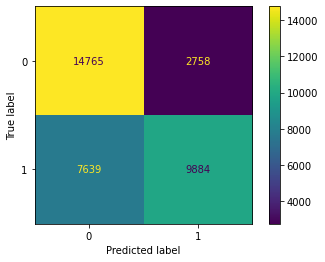

In [55]:
# Trainset
pred_logreg_train = logreg.predict(X_train_oversampled)
cm_train = confusion_matrix(Y_train_oversampled, pred_logreg_train)
ConfusionMatrixDisplay(confusion_matrix=cm_train,display_labels=logreg.classes_).plot()
print("Trainset Accuracy: ",accuracy_score(Y_train_oversampled, pred_logreg_train))

Testset Accuracy:  0.78


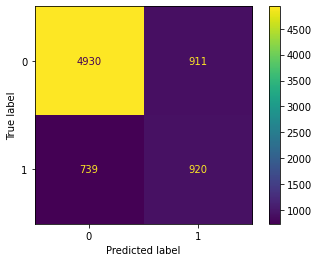

In [56]:
# Testset
pred_logreg_test = logreg.predict(X_test_scaled)
cm_test = confusion_matrix(Y_test, pred_logreg_test)
ConfusionMatrixDisplay(confusion_matrix=cm_test,display_labels=logreg.classes_).plot()
print("Testset Accuracy: ",accuracy_score(Y_test, pred_logreg_test))

### Ignore everything below 

In [41]:
X

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_1_-1,PAY_1_0,PAY_1_1,PAY_1_2,PAY_1_3,PAY_1_4,PAY_1_5,PAY_1_6,PAY_1_7,PAY_1_8,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,20000,24,3913,3102,689,0,0,0,0,689,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,39,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
29996,150000,43,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
29997,30000,37,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
29998,80000,41,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [42]:
# Scaling
for i in X.columns:
    X[i]=stats.zscore(X[i].astype(float))
print(X)

       LIMIT_BAL       AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  \
0      -1.136720 -1.246020  -0.642501  -0.647399  -0.667993  -0.672497   
1      -0.365981 -1.029047  -0.659219  -0.666747  -0.639254  -0.621636   
2      -0.597202 -0.161156  -0.298560  -0.493899  -0.482408  -0.449730   
3      -0.905498  0.164303  -0.057491  -0.013293   0.032846  -0.232373   
4      -0.905498  2.334029  -0.578618  -0.611318  -0.161189  -0.346997   
...          ...       ...        ...        ...        ...        ...   
29995   0.404759  0.381275   1.870379   2.018136   2.326690   0.695474   
29996  -0.134759  0.815221  -0.672786  -0.665299  -0.627430  -0.532924   
29997  -1.059646  0.164303  -0.647227  -0.643830  -0.638158  -0.347961   
29998  -0.674276  0.598248  -0.717982   0.410269   0.422373   0.147844   
29999  -0.905498  1.140680  -0.044739  -0.003851   0.039667  -0.104582   

       BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  \
0      -0.663059  -0.652724 -0

In [ ]:
# Doesn't look right to select certain features